In [1]:
import numpy as np
import pickle
import math
import keras
import time
from datetime import timedelta
import datetime
import pandas as pd
import random
from src import utils, trnvaltst_sigmoid_oned, TGCNN_layer, whole_model, whole_model_demographics, create_fake_patients, plot_figures
from early_stopping_cv import EarlyStopping
from tensorflow import keras
import tensorflow as tf
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, roc_auc_score, recall_score
from csv import writer
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
print("tensorflow version:", tf. __version__)
tf.config.list_physical_devices()

tensorflow version: 2.10.1


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [2]:
no_LSTM = False # True = without LSTM
exponential_scaling = True # True = with exponential
L1_ablation = True # True = with L1 reg
L2_ablation = True # True = with L2 reg
variable_gamma = True
graph_reg_incl = True

num_of_runs = 1
start_num = 1
    
weighted_loss = False # class weighted to deal with imbalance if True
no_timestamp = False # if no_timestamp = True then all values in 3-tensor = 1
activation_type = 'LeakyReLU' #'relu','gelu', 'LeakyReLU'
second_TGCNN_layer = True
demo = True
include_drugs = True
max_timesteps=100

run_name='hip_1999_to_one_year_advance_model'

# strings for hyperparameter searching file
LSTM_str="LSTM excluded" if no_LSTM == True else "LSTM included"
exp_str = "exp excluded" if exponential_scaling == False else "exp included"
timestamp_str = "time elapsed = 1" if no_timestamp == True else "time elapsed"
weighted_loss_str = "weighted_loss" if weighted_loss ==True else "unweighted_loss"
L1_str = "L1 included" if L1_ablation == True else "L1 excluded"
L2_str = "L2 included" if L2_ablation == True else "L2 excluded"
second_layer_str = "Branched model" if second_TGCNN_layer == True else "Unbranched model"

In [3]:
if include_drugs:
    max_event_codes = 518
else:
    max_event_codes = 512
num_labels = 1 # number of outcomes -1 
hip_or_knee = 'hip'
class_weights = tf.compat.v2.constant([[0.5, 0.5]]) # 50:50 split for the class weights

# This would be where you would import your data instead of using the `create_fake_patient_df` function
    # Data to train the model on 
cv_patients = create_fake_patients.create_fake_patient_df(num_patients=500, max_events=100, max_nodes=512)
    # Data to test and relicibrate on
test_patients = create_fake_patients.create_fake_patient_df(num_patients=500, max_events=100, max_nodes=512)
    # Data to test the recalibrated model on
recal_test_patients = create_fake_patients.create_fake_patient_df(num_patients=500, max_events=100, max_nodes=512)

cv_patients

,user,indices,values,num_time_steps,gender,imd_quin,age_at_label_event,replace_type,indices_len
0,0,"[[274, 16, 100], [66, 274, 99], [204, 66, 98],...","[0.46851399087389056, 0.00279628129287135, 0.5...",13,1,5.0,56.0,none,13
1,1,"[[332, 437, 100], [150, 332, 99], [408, 150, 9...","[0.17181160466637624, 0.21759865122765043, 0.6...",14,1,2.0,56.0,hip,14
2,2,"[[76, 9, 100], [359, 76, 99], [439, 359, 98], ...","[0.19195780748596525, 0.9388225776330265, 0.25...",96,0,5.0,68.0,hip,96
3,3,"[[28, 295, 100], [88, 28, 99], [161, 88, 98]]","[0.3246148095895658, 0.9208701624201637, 0.502...",3,0,2.0,78.0,hip,3
4,4,"[[120, 48, 100], [160, 120, 99], [377, 160, 98...","[0.9304034488211084, 0.49527256840638856, 0.67...",69,0,3.0,80.0,hip,69
...,...,...,...,...,...,...,...,...,...
495,495,"[[440, 504, 100], [350, 440, 99], [195, 350, 9...","[0.2944809478723903, 0.36029190558818736, 0.28...",36,1,1.0,60.0,hip,36
496,496,"[[431, 435, 100], [29, 431, 99], [511, 29, 98]...","[0.025508044139050168, 0.9942570938464158, 0.0...",8,1,2.0,52.0,none,8
497,497,"[[322, 405, 100], [498, 322, 99], [499, 498, 9...","[0.7685552437455493, 0.7233921389692002, 0.352...",41,0,1.0,80.0,hip,41
498,498,"[[342, 96, 100], [280, 342, 99], [14, 280, 98]...","[0.12213932063230615, 0.16040050835608777, 0.2...",31,1,4.0,83.0,none,31


In [4]:
cv_sample_size = len(cv_patients)
test_sample_size = len(test_patients)
recal_test_sample_size = len(recal_test_patients)


indices_len_cv = cv_patients['indices_len'].max() 
indices_len_test = test_patients['indices_len'].max()
indices_len_recal = recal_test_patients['indices_len'].max()
max_indices_len = max(indices_len_cv, indices_len_test, indices_len_recal)

max_indices_len = max_indices_len + 1

In [5]:
cv_y = utils.get_labels_binary(cv_patients, hip_or_knee)
test_y = utils.get_labels_binary(test_patients, hip_or_knee)
recal_test_y = utils.get_labels_binary(recal_test_patients, hip_or_knee)

utils.check_group_sizes(cv_patients, test_patients, cv_y, test_y)

Number of people in the cv input data 500
Number of people in cv label data: 500
Number of people in the test input data 500
Number of people in test label data: 500
Number of patients in each class in cv set:
replace_type
hip     269
none    231
Name: count, dtype: int64

Number of patients in each class in test set:
replace_type
hip     259
none    241
Name: count, dtype: int64


#### Convert list of lists of event codes into Sparse Tensor

In [6]:
cv_input_matrices = utils.create_sparse_tensors(cv_sample_size, cv_patients, max_event_codes, max_indices_len, 'cv')
test_input_matrices = utils.create_sparse_tensors(test_sample_size, test_patients, max_event_codes, max_indices_len, 'test')
recal_test_input_matrices = utils.create_sparse_tensors(recal_test_sample_size, recal_test_patients, max_event_codes, max_indices_len, 'recal_test')

cv : converting from input matrices to SparseTensors
0/500 converted to SparseTensors 0.00%
test : converting from input matrices to SparseTensors
0/500 converted to SparseTensors 0.00%
recal_test : converting from input matrices to SparseTensors
0/500 converted to SparseTensors 0.00%


#### Hyperparameter tuning, model 5-fold-cv training and testing.

Run name: hip_1999_to_one_year_advance_model 1
Number of epochs: 1
Learning rate: 0.0001
Number of 3D CNN filters: 16
Filter size: 4
Number of LSTM neurons: 64
Number of fully connected layers: 128
Dropout value: 0.7
Regularisation strength: 1e-05
****************************************
hip_1999_to_one_year_advance_model1_split1
normalised gamma [[0.00017164]]
normalised gamma [[-0.05972205]]

Epoch 1/1
Gamma: 0.0002895655925385654
Gamma 2: -0.059884000569581985

TRAINING METRICS:
Training AUC: 0.5086
Train loss 7.4976
Train accuracy: 52.2500%
Train calibration slope: -4.1147

VALIDATION METRICS:
Validation AUC: 0.5000
Validation loss: 7.4303
Validation accuracy: 52.0000%
Validation calibration slope: 0.4984


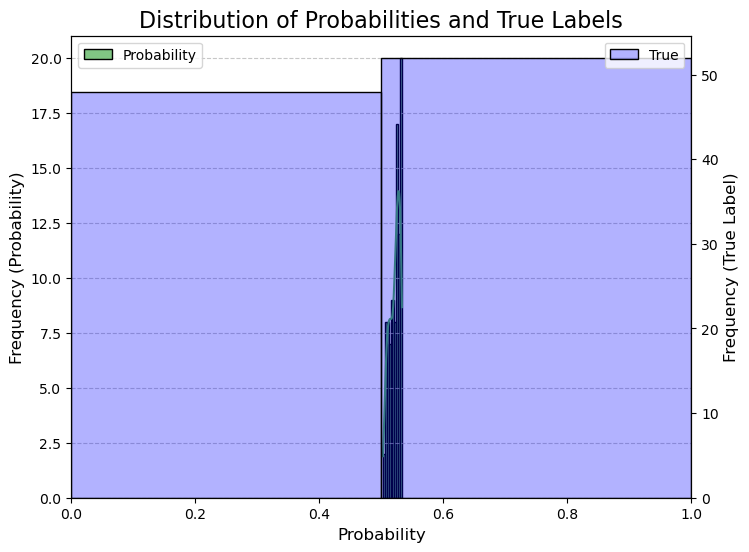

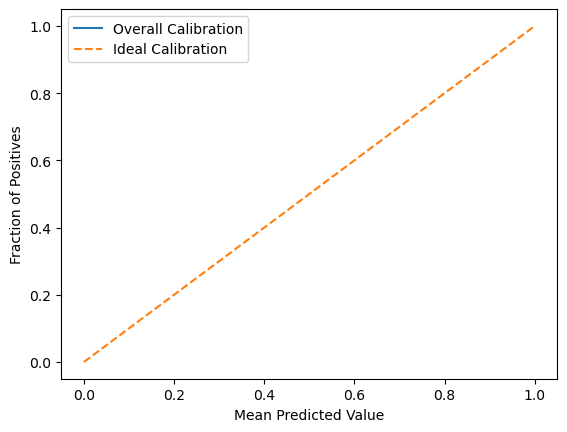

Validation loss decreased (inf --> 7.430270).
Model weights saving...


UnknownError: {{function_node __wrapped__SaveV2_dtypes_30_device_/job:localhost/replica:0/task:0/device:CPU:0}} Failed to WriteFile: hip_1999_to_one_year_advance_model1_CNN_layer_temp/part-00000-of-00001.data-00000-of-00001.tempstate1314186509813749546 : There is not enough space on the disk.
; operation in progress [Op:SaveV2]

In [7]:
%%time
cv_size = int(round(cv_sample_size*0.2)) # 1/5th of cv data
holdout_size = len(test_patients)


for ran_search_num in range(start_num, start_num+num_of_runs):
    print('Run name:', run_name, str(ran_search_num))
    cv_indices = list(range(len(cv_input_matrices)))
    test_indices = list(range(len(test_input_matrices)))
    recal_test_indices = list(range(len(recal_test_input_matrices)))
    #unmatched_test_indices = list(range(len(unmatched_input_matrices)))
    random.shuffle(cv_indices) # shuffles datasets
    random.shuffle(test_indices) # shuffles datasets
    random.shuffle(recal_test_indices)
    #random.shuffle(unmatched_test_indices)
    
    cv_split1_indices = cv_indices[:cv_size]
    cv_split2_indices = cv_indices[cv_size:2*cv_size]
    cv_split3_indices = cv_indices[2*cv_size:3*cv_size]
    cv_split4_indices = cv_indices[3*cv_size:4*cv_size]
    cv_split5_indices = cv_indices[4*cv_size:5*cv_size]


    batch_size = 64

    batched_graphs_split1, batched_labels_split1, batched_cv_split1_indices = utils.batch_set(indice_set=cv_split1_indices, input_matrices=cv_input_matrices, 
                                                       labels=cv_y.to_numpy(), batchsize=batch_size)
    batched_graphs_split2, batched_labels_split2, batched_cv_split2_indices = utils.batch_set(indice_set=cv_split2_indices, input_matrices=cv_input_matrices, 
                                                       labels=cv_y.to_numpy(), batchsize=batch_size)
    batched_graphs_split3, batched_labels_split3, batched_cv_split3_indices = utils.batch_set(indice_set=cv_split3_indices, input_matrices=cv_input_matrices, 
                                                       labels=cv_y.to_numpy(), batchsize=batch_size)
    batched_graphs_split4, batched_labels_split4, batched_cv_split4_indices = utils.batch_set(indice_set=cv_split4_indices, input_matrices=cv_input_matrices, 
                                                       labels=cv_y.to_numpy(), batchsize=batch_size)
    batched_graphs_split5, batched_labels_split5, batched_cv_split5_indices = utils.batch_set(indice_set=cv_split5_indices, input_matrices=cv_input_matrices, 
                                                       labels=cv_y.to_numpy(), batchsize=batch_size)
    
    
    batched_graphs_holdout, batched_labels_holdout, batched_holdout_indices = utils.batch_set(indice_set=test_indices, input_matrices=test_input_matrices, 
                                                         labels=test_y.to_numpy(), batchsize=batch_size)
    labels_holdout = [item for sublist in batched_labels_holdout for item in sublist]
    
    batched_graphs_holdout2, batched_labels_holdout2, batched_holdout2_indices = utils.batch_set(indice_set=recal_test_indices, input_matrices=recal_test_input_matrices, 
                                                         labels=recal_test_y.to_numpy(), batchsize=batch_size)
    labels_holdout2 = [item for sublist in batched_labels_holdout2 for item in sublist]
    
#     batched_graphs_unmatch, batched_labels_unmatch, batched_unmatch_indices = utils.batch_set(indice_set=unmatched_test_indices, input_matrices=unmatched_input_matrices, 
#                                                          labels=unmatched_y.to_numpy(), batchsize=batch_size)
#     labels_unmatch = [item for sublist in batched_labels_unmatch for item in sublist]
    

    
    # Save the true labels for analysis later
    file_full_name_true = 'pred_proba_and_true/'+run_name+str(ran_search_num)+'_holdout1_true.npy'
    with open(file_full_name_true, 'wb') as f:
        np.save(f, labels_holdout)
        
    file_full_name_true2 = 'pred_proba_and_true/'+run_name+str(ran_search_num)+'_holdout2_true.npy'
    with open(file_full_name_true2, 'wb') as f:
        np.save(f, labels_holdout2)
    
#     file_full_name_true3 = 'pred_proba_and_true/'+run_name+str(ran_search_num)+'_unmatch_true.npy'
#     with open(file_full_name_true3, 'wb') as f:
#         np.save(f, labels_unmatch)
    
    
    # split cv data into batches for training
    graphs_train1, graphs_train2, graphs_train3, graphs_train4, graphs_train5, graphs_test1, graphs_test2, \
    graphs_test3, graphs_test4, graphs_test5, labels_train1, labels_train2, labels_train3, labels_train4, \
    labels_train5, labels_test1, labels_test2, labels_test3, labels_test4, labels_test5, indices_train1, \
    indices_train2, indices_train3, indices_train4, indices_train5, indices_test1, indices_test2, indices_test3, \
    indices_test4, indices_test5, \
    = utils.get_cv_groups(batched_graphs_split1, batched_graphs_split2, batched_graphs_split3, batched_graphs_split4, 
                    batched_graphs_split5, batched_labels_split1, batched_labels_split2, batched_labels_split3, 
                    batched_labels_split4, batched_labels_split5, batched_cv_split1_indices, batched_cv_split2_indices, 
                    batched_cv_split3_indices, batched_cv_split4_indices, batched_cv_split5_indices)

    nepochs=1
    lr = random.choice([0.001, 0.005, 0.0001]) # initial learning rate

    # out_chans = random.choice([8, 16, 32]) # number of filters
    # filter_size = random.choice([3, 4, 6]) # number of time steps/ filter size
    # if no_LSTM:
    #     lstm_h = 0
    # else:
    #     lstm_h = random.choice([16, 32, 64, 128, 256]) # number of LSTM neurons
    # linear_size = random.choice([64, 128]) # linear layer output size
    # #drop_val = random.choice([0.2, 0.3, 0.4, 0.5])
    # drop_val = random.choice([0.5, 0.6, 0.7, 0.8, 0.9])
    reg_strength = random.choice([1e-2, 5e-2, 1e-3, 5e-3, 1e-4, 5e-4, 1e-5])
    # #reg_strength = random.choice([100, 10, 1, 1e-1, 5e-1])
    graph_reg_strength = 1e1
    out_chans = 16
    filter_size = 4
    lstm_h = 64
    linear_size = 128
    drop_val=0.7

    


    print(f"Number of epochs: {nepochs}")
    print(f"Learning rate: {lr}")
    print(f"Number of 3D CNN filters: {out_chans}")
    print(f"Filter size: {filter_size}")
    print(f"Number of LSTM neurons: {lstm_h}")
    print(f"Number of fully connected layers: {linear_size}")
    print(f"Dropout value: {drop_val}")
    print(f"Regularisation strength: {reg_strength}")
    print("*"*40)
    

    #############################################
    ####### FOR LOOP FOR CV HERE  ###############
    #############################################
    
    cv_accuracy, cv_auc, cv_cal_slope = [], [], []
    best_metric = 0
    for split in range(0, 5):
        run_split_name = run_name + str(ran_search_num) +"_split" + str(split+1)
        print(run_split_name)
        
        if demo:
            model = whole_model_demographics.TGCNN_Model(num_filters=out_chans, num_nodes=max_event_codes, num_time_steps=max_timesteps, 
                            filter_size=filter_size, variable_gamma=variable_gamma, 
                            exponential_scaling=exponential_scaling, dropout_rate=drop_val, lstm_units=lstm_h,
                            fcl1_units=linear_size, LSTM_ablation=no_LSTM, stride=1, activation_type=activation_type, 
                            no_timestamp=no_timestamp, second_TGCNN_layer=second_TGCNN_layer, num_labels=num_labels)
        else:
            model = whole_model.TGCNN_Model(num_filters=out_chans, num_nodes=max_event_codes, num_time_steps=max_timesteps, 
                            filter_size=filter_size, variable_gamma=variable_gamma, 
                            exponential_scaling=exponential_scaling, dropout_rate=drop_val, lstm_units=lstm_h,
                            fcl1_units=linear_size, LSTM_ablation=no_LSTM, stride=1, activation_type=activation_type, 
                            no_timestamp=no_timestamp, second_TGCNN_layer=second_TGCNN_layer, num_labels=num_labels)
    
        early_stopping = EarlyStopping(patience=5, verbose=True)


        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=lr,
            decay_steps=1000,
            decay_rate=0.9)

        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
        
        if split+1 == 1:
            batched_graphs_trn, batched_labels_trn = graphs_train1, labels_train1
            batched_graphs_val, batched_labels_val = graphs_test1, labels_test1
            train_indices = indices_train1
            test_indices = indices_test1
            
        elif split+1 == 2:
            batched_graphs_trn, batched_labels_trn = graphs_train2, labels_train2
            batched_graphs_val, batched_labels_val = graphs_test2, labels_test2
            train_indices = indices_train2
            test_indices = indices_test2
            
        elif split+1 == 3:
            batched_graphs_trn, batched_labels_trn = graphs_train3, labels_train3
            batched_graphs_val, batched_labels_val = graphs_test3, labels_test3
            train_indices = indices_train3
            test_indices = indices_test3
            
        elif split+1 == 4:
            batched_graphs_trn, batched_labels_trn = graphs_train4, labels_train4
            batched_graphs_val, batched_labels_val = graphs_test4, labels_test4
            train_indices = indices_train4
            test_indices = indices_test4
            
        elif split+1 == 5:
            batched_graphs_trn, batched_labels_trn = graphs_train5, labels_train5
            batched_graphs_val, batched_labels_val = graphs_test5, labels_test5
            train_indices = indices_train5
            test_indices = indices_test5
            
        
        start_time = time.monotonic()

        train_loss_epochs, train_acc_epochs, train_prec_epochs, train_recall_epochs, train_f1_epochs, train_auc_epochs = [],[],[],[],[],[]
        #train_indiv_acc_epochs, train_indiv_prec_epochs, train_indiv_recall_epochs, train_indiv_f1_epochs, train_indiv_auc_epochs = [],[],[],[],[]
        val_loss_epochs, val_acc_epochs, val_prec_epochs, val_recall_epochs, val_f1_epochs, val_auc_epochs = [],[],[],[],[],[]
        #val_indiv_acc_epochs, val_indiv_prec_epochs, val_indiv_recall_epochs, val_indiv_f1_epochs, val_indiv_auc_epochs = [],[],[],[],[]

        for epoch in range(nepochs):
            #if epoch % 10 == 0:
            print(f"\nEpoch {epoch+1}/{nepochs}")

            # Iterate over the batches of the dataset.
            train_loss_list, train_acc_list, train_prec_list, train_recall_list, train_f1_list, train_auc_list = [],[],[],[],[],[]
            train_logits_list = []

            for x_batch_train, y_batch_train, train_indices_list in zip(batched_graphs_trn, batched_labels_trn, train_indices):
                # need to get one list at a time from the list of lists   
                trn_demo_vals, trn_demo_list, pat_num = utils.convert_demos_to_tensor(cv_patients, train_indices_list, demo)
                
                if demo == False:
                    trn_demo_vals = None
                    trn_demo_list = None
                
                y_batch_train=np.array(y_batch_train)
                trn_logits, trn_loss, trn_acc, trn_prec, trn_recall, trn_auc, trn_f1, \
                model = trnvaltst_sigmoid_oned.train_step(x_batch_train, y_batch_train, trn_demo_vals,
                                                        reg_strength,class_weights,model,L1_ablation,L2_ablation, 
                                                       graph_reg_strength, graph_reg_incl, exponential_scaling,
                                                       weighted_loss, variable_gamma, optimizer, demo)

                train_loss_list.append(trn_loss)
                train_acc_list.append(trn_acc)
                train_prec_list.append(trn_prec)
                train_recall_list.append(trn_recall)
                train_auc_list.append(trn_auc)
                train_f1_list.append(trn_f1)
                train_logits_list = train_logits_list + trn_logits.numpy().tolist()

            if variable_gamma and (exponential_scaling==True):
                gamma_val = float(model.tg_conv_layer1.gammat.numpy())
                print("Gamma:", gamma_val)
                if second_TGCNN_layer:
                    gamma_val2 = float(model.tg_conv_layer2.gammat.numpy())
                    print("Gamma 2:", gamma_val2)


            print("\nTRAINING METRICS:")
            print(f"Training AUC: {np.mean(train_auc_list):.4f}")
            print(f"Train loss {np.mean(train_loss_list):.4f}")
            print(f"Train accuracy: {np.mean(train_acc_list) :.4%}")

            flattened_train_labels = [int(item) for sublist in batched_labels_trn for array in sublist for item in array]
            train_cal_slope = utils.calibration_slope(flattened_train_labels, train_logits_list)
            print(f"Train calibration slope: {train_cal_slope:.4f}")


            # Validation loop
            val_loss_list, val_acc_list,  val_prec_list, val_recall_list, val_auc_list, val_f1_list = [],[],[],[],[],[]
            val_logits_list = []
            for x_batch_val, y_batch_val, test_indices_list in zip(batched_graphs_val, batched_labels_val, test_indices):
                
                test_demo_vals, test_demo_list, pat_num = utils.convert_demos_to_tensor(cv_patients, test_indices_list, demo)                
                
                if demo == False:
                    test_demo_vals = None
                
                val_logits, val_loss, val_acc, val_prec, val_recall, val_auc, val_f1, \
                model = trnvaltst_sigmoid_oned.val_step(x_batch_val, y_batch_val, test_demo_vals, reg_strength, 
                                                  class_weights, model, L1_ablation, L2_ablation, 
                                                  graph_reg_strength, graph_reg_incl, weighted_loss, demo)

                val_loss_list.append(val_loss)
                val_acc_list.append(val_acc)
                val_prec_list.append(val_prec)
                val_recall_list.append(val_recall) 
                val_auc_list.append(val_auc)
                val_f1_list.append(val_f1)
                val_logits_list = val_logits_list + val_logits.numpy().tolist()
            
            
            
            
            # Saves the logits if the AUC improves
            improved_metric = False
            if np.mean(val_auc_list) > best_metric:
                best_metric = np.mean(val_auc_list)
                improved_metric = True

            print("\nVALIDATION METRICS:")
            print(f"Validation AUC: {np.mean(val_auc_list):.4f}")
            print(f"Validation loss: {np.mean(val_loss_list):.4f}")
            print(f"Validation accuracy: {np.mean(val_acc_list) :.4%}")

            flattened_val_labels = [int(item) for sublist in batched_labels_val for array in sublist for item in array]
            val_cal_slope = utils.calibration_slope(flattened_val_labels, val_logits_list)
            print(f"Validation calibration slope: {val_cal_slope:.4f}")
            
            #plot_figures.draw_confusion_mat(y_batch_val, val_logits, ['none','hip'], run_name=None, ran_search_num=1111, data_type="V")
            plot_figures.draw_calibration_curve(np.array(flattened_val_labels), np.array(val_logits_list), run_name=None, ran_search_num=1111)

            print("="*50)
            # get the average metric from ONE epoch
            ave_epoch_train_loss, ave_epoch_train_acc, ave_epoch_train_auc, ave_epoch_train_prec, ave_epoch_train_recall, ave_epoch_train_f1 = np.mean(train_loss_list), np.mean(train_acc_list), np.mean(train_auc_list), np.mean(train_prec_list), np.mean(train_recall_list), np.mean(train_f1_list)
            ave_epoch_val_loss, ave_epoch_val_acc, ave_epoch_val_auc, ave_epoch_val_prec, ave_epoch_val_recall, ave_epoch_val_f1 = np.mean(val_loss_list), np.mean(val_acc_list), np.mean(val_auc_list), np.mean(val_prec_list), np.mean(val_recall_list), np.mean(val_f1_list)        


            #print(optimizer.get_config())

            # save the average (from one epoch) to the list of ALL epochs
            utils.metric_save(ave_epoch_train_loss, train_loss_epochs, ave_epoch_val_loss, val_loss_epochs) #losses
            utils.metric_save(ave_epoch_train_acc, train_acc_epochs, ave_epoch_val_acc, val_acc_epochs) # acc
            utils.metric_save(ave_epoch_train_auc, train_auc_epochs, ave_epoch_val_auc, val_auc_epochs) # auc        
            utils.metric_save(ave_epoch_train_prec, train_prec_epochs, ave_epoch_val_prec, val_prec_epochs) # prec
            utils.metric_save(ave_epoch_train_recall, train_recall_epochs, ave_epoch_val_recall, val_recall_epochs) # recall
            utils.metric_save(ave_epoch_train_f1, train_f1_epochs, ave_epoch_val_f1, val_f1_epochs) #f1


            early_stopping_metric = val_loss_list # metric that is used to determine if the model should stop training
            early_stopping(np.mean(early_stopping_metric), train_loss_list, val_loss_list, 
                           train_cal_slope, val_cal_slope,
                           train_acc_list, val_acc_list,  
                           train_auc_list, val_auc_list,
                           #train_auc_indiv_ave, val_auc_indiv_ave,
                           train_prec_list, val_prec_list,
                           #train_prec_indiv_ave, val_prec_indiv_ave,
                           train_recall_list, val_recall_list,
                           #train_recall_indiv_ave, val_recall_indiv_ave,
                           train_f1_list, val_f1_list,
                           #train_f1_indiv_ave, val_f1_indiv_ave, 
                           model, run_name+str(ran_search_num),
                           batched_graphs_holdout, batched_labels_holdout, batched_holdout_indices,
                           batched_graphs_holdout2, batched_labels_holdout2, batched_holdout2_indices,
                           #batched_graphs_unmatch, batched_labels_unmatch, batched_unmatch_indices,
                           reg_strength,
                           class_weights, L1_ablation, L2_ablation, graph_reg_strength, graph_reg_incl, weighted_loss, 
                           improved_metric, test_patients, recal_test_patients, 
                           #unmatched_pats, 
                           demo, save_filters = True)

            if early_stopping.checkpoint_made:

                checkpoint_train_loss, checkpoint_val_loss, \
                checkpoint_train_cal_slope, checkpoint_val_cal_slope, \
                checkpoint_train_acc, checkpoint_val_acc, \
                checkpoint_train_auc, checkpoint_val_auc, \
                checkpoint_train_prec, checkpoint_val_prec,  \
                checkpoint_train_recall, checkpoint_val_recall, \
                checkpoint_train_f1, checkpoint_val_f1 = early_stopping.print_checkpoint_metric(train_loss_list,
                                                                            val_loss_list, 
                                                                            train_cal_slope, val_cal_slope,
                                                                            train_acc_list, val_acc_list, 
                                                                            train_auc_list, val_auc_list, 
                                                                            train_prec_list, val_prec_list,                                    
                                                                            train_recall_list, val_recall_list,                                       
                                                                            train_f1_list, val_f1_list)


            if early_stopping.early_stop:
                print("Early stopping")
                break



        if variable_gamma and (exponential_scaling==True):
            gamma_val = float(model.tg_conv_layer1.gammat.numpy())
            print("Gamma:", gamma_val)
            if second_TGCNN_layer:
                gamma_val2 = float(model.tg_conv_layer2.gammat.numpy())
                print("Gamma 2:", gamma_val2)
                
        else:
            gamma_val = 'N/A'

        end_time = time.monotonic()
        time_taken = timedelta(seconds=end_time - start_time)

        list_for_csv = [run_split_name+"_"+str(ran_search_num), nepochs, epoch+1, str(time_taken), lr, out_chans, filter_size, 
                        lstm_h, reg_strength,
                       linear_size, drop_val, batch_size,

                        min(train_loss_epochs), max(train_loss_epochs), min(val_loss_epochs), 
                        max(val_loss_epochs), checkpoint_train_loss, checkpoint_val_loss,                    

                        min(train_auc_epochs), max(train_auc_epochs), min(val_auc_epochs), 
                        max(val_auc_epochs), checkpoint_train_auc, checkpoint_val_auc,                  

                        min(train_acc_epochs), max(train_acc_epochs), min(val_acc_epochs), 
                        max(val_acc_epochs), checkpoint_train_acc, checkpoint_val_acc,

                        min(train_prec_epochs), max(train_prec_epochs), min(val_prec_epochs), 
                        max(val_prec_epochs), checkpoint_train_prec, checkpoint_val_prec,   

                        min(train_recall_epochs), max(train_recall_epochs), min(val_recall_epochs), 
                        max(val_recall_epochs), checkpoint_train_recall, checkpoint_val_recall,  

                        min(train_f1_epochs), max(train_f1_epochs), min(val_f1_epochs), 
                        max(val_f1_epochs), checkpoint_train_f1, checkpoint_val_f1, 

                        gamma_val, 
                        checkpoint_train_cal_slope, checkpoint_val_cal_slope,
                        activation_type, LSTM_str, exp_str, timestamp_str, weighted_loss_str, L1_str, L2_str,
                        second_layer_str]



        with open('tgcnn_hip_and_knee_results.csv', 'a', newline='') as f_object:
            writer_object = writer(f_object)
            writer_object.writerow(list_for_csv)
            f_object.close()


        # to save .npy files containing metrics over the epochs
        with open("npy_metrics/metric_vals_"+run_name+"_"+str(ran_search_num)+".npy", 'wb') as f:
            np.save(f, np.array(train_loss_epochs))
            np.save(f, np.array(val_loss_epochs))

            np.save(f, np.array(train_acc_epochs))
            np.save(f, np.array(val_acc_epochs))

            np.save(f, np.array(train_auc_epochs))
            np.save(f, np.array(val_auc_epochs))

            np.save(f, np.array(train_prec_epochs))
            np.save(f, np.array(val_prec_epochs))

            np.save(f, np.array(train_recall_epochs))
            np.save(f, np.array(val_recall_epochs))

            np.save(f, np.array(train_f1_epochs))
            np.save(f, np.array(val_f1_epochs))    


        print("\nCHECKPOINTED RESULTS")
        print(f"Train loss: {checkpoint_train_loss:.4f}") # average loss from the epoch
        print(f"Train AUC: {checkpoint_train_auc:.4%}\n")
        print(f"Val loss: {checkpoint_val_loss:.4f}") # average loss from the epoch
        print(f"Val AUC: {checkpoint_val_auc:.4%}\n")

        print("="*50)
        print("="*50)
        
        cv_accuracy.append(checkpoint_val_acc)
        cv_auc.append(checkpoint_val_auc)
        cv_cal_slope.append(checkpoint_val_cal_slope)
        
    print(f"5-fold CV Accuracy on (Validation Set): {np.mean(cv_accuracy):.4f} +/- {np.std(cv_accuracy):.4f}")
    print(f"5-fold CV AUC on (Validation Set): {np.mean(cv_auc):.4f} +/- {np.std(cv_auc):.4f}")
    print(f"5-fold CV Calibration Slope (Validation Set): {np.mean(cv_cal_slope):.4f} +/- {np.std(cv_cal_slope):.4f}")
    print("*"*100)
        
    # class_names = ['none', 'hip']
#     plot_figures.plot_loss_curve(train_loss = train_loss_epochs, val_loss = val_loss_epochs, test_lost = test_loss_epochs, 
#                     run_name=run_split_name, ran_search_num=ran_search_num)


    # # open the proba file and then plot the figures for the test data
    # # The model is tested during early stopping
    # with open('pred_proba_and_true/'+run_name+str(ran_search_num)+'_holdout1_proba.npy', 'rb') as f:
    #     test_logits = np.load(f)

    #plot_figures.draw_confusion_mat(labels_holdout, test_logits, class_names, run_name, ran_search_num)
    #plot_figures.draw_calibration_curve(labels_holdout, test_logits, run_name, ran_search_num)
    


In [8]:
model.summary()

Model: "tgcnn__model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.
 tg_conv_layer1 (TGCNN_layer  multiple                 17172737  
 )                                                               
                                                                 
 tg_conv_layer2 (TGCNN_layer  multiple                 17172737  
 )                                                               
                                                                 
 batch_normalization (BatchN  multiple                 388       
 ormalization)                                                   
                                                                 
 batch_normalization_1 (Batc  multiple                 196       
 hNormalization)                            